# Lab 2 Kalman Filter - Car Tracking

### SIC7001 Signal Enhancement Methods
### Mochamad Ardiansyah NUGRAHA

In [1]:
import numpy as np
from scipy.linalg import expm
from scipy.integrate import trapz
import matplotlib.pyplot as plt

In [2]:
## CONTINUOUS TIME MODEL ##

# process noise wt, covariance matrix
q = 1
Qc = np.array([[q, 0], [0, q]])

# measurement noise nt, covariance matrix
s = 2
R = np.array([[s**2, 0], [0, s**2]])

# state equation: xt = [px, py, pdot_x, pdot_y]^T
def state_cont(px, py, pdot_x, pdot_y):
    return np.array([px, py, pdot_x, pdot_y])

# state-space: xdot = Ac.xt + B.wt
Ac = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0]])
B = np.array([[0, 0], [0, 0], [1, 0], [0, 1]])
def state_space_cont(Ac, x, B, w):
    return np.dot(Ac, x) + np.dot(B, w)

# measurement: yt = C.xt + nt
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
def measurement_cont(C, x, n):
    return np.dot(C, x) + n

## Problem 1: Discrete Time Model

### Problem 1.1: Calculate A, C

In [3]:
# sampling time
Ts = 0.1

# compute transition matrix: A
def A_disc(Ac, Ts):
    A = expm(Ac * Ts)
    return A

A = A_disc(Ac, Ts)
print("A:", A)
print("C:", C)

A: [[1.  0.  0.1 0. ]
 [0.  1.  0.  0.1]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]]
C: [[1 0 0 0]
 [0 1 0 0]]


### Problem 1.2: Calculate Cov(q)

In [4]:
Sigma_w = Qc

def integrand(A, Ts, t, B, Sigma_w):
    return np.dot(
        np.dot(np.dot(np.dot(expm(A * (Ts - t)), B), Sigma_w), 
               np.transpose(B)),
        np.transpose(expm(A * (Ts - t))),
    )

def integrate_matrix(A, Ts, B, Sigma_w, num_steps=1000):
    t_values = np.linspace(0, Ts, num_steps)
    integrand_values = np.array([integrand(A, Ts, t, B, Sigma_w) for t in t_values])
    integrated_matrix = trapz(integrand_values, x=t_values, axis=0)
    return integrated_matrix

Cov_q = integrate_matrix(A, Ts, B, Sigma_w)
print("Cov_q:", Cov_q)

Cov_q: [[3.87565647e-06 0.00000000e+00 5.71944876e-04 0.00000000e+00]
 [0.00000000e+00 3.87565647e-06 0.00000000e+00 5.71944876e-04]
 [5.71944876e-04 0.00000000e+00 1.10701379e-01 0.00000000e+00]
 [0.00000000e+00 5.71944876e-04 0.00000000e+00 1.10701379e-01]]


## Problem 2: Simulated Data

### Problem 2.1

In [5]:
# new process noise w (R^2)
mean_w = np.zeros(2)
Cov_w = np.identity(2)

# white Gaussian noise v, covariance matrix
mean_v = np.zeros(2)
Cov_v = np.array([[2, -1], [-1, 2]])

w = np.random.multivariate_normal(mean_w, Cov_w)
L = np.linalg.cholesky(Cov_v)

v = np.dot(L, w)

print("v:", v)

v: [2.21869804 0.40587718]


### Problem 2.2

In [6]:
# discrete model
def discrete_model(A, xk_prev, qk_prev, C, rk):
    xk = np.dot(A, xk_prev) + qk_prev
    yk = np.dot(C, xk) + rk
    return xk, yk

# Gaussian process x0, mean m0, covariance matrix P0
m0 = np.array([0, 0, 1, -1])
P0 = np.identity(4)

# number of steps
N = 100

mean_q = np.zeros(4)
mean_r = np.zeros(2)

x = np.zeros((N, 4)) 
y = np.zeros((N, 2))
q = np.zeros((N, 4))
r = np.zeros((N, 2))
# print(x.shape)
# print(y.shape)

# calculate state
r[0] = np.random.multivariate_normal(mean_r, R)
x[0] = np.random.multivariate_normal(m0, P0)
y[0] = np.dot(C, x[0]) + r[0]

for k in range(N - 1):
    q[k] = np.random.multivariate_normal(mean_q, Cov_q)
    r[k + 1] = np.random.multivariate_normal(mean_r, R)
    x[k + 1], y[k + 1] = discrete_model(A=A, xk_prev=x[k], qk_prev=q[k], C=C, rk=r[k + 1])
    print(f"x[{k}]: ", x[k])
    print(f"y[{k}]: ", y[k])

x[0]:  [-0.61516923  0.51834352  1.30879045 -1.48397562]
y[0]:  [-5.13931922  1.60421982]
x[1]:  [-0.48934953  0.36950602  0.69753874 -1.141754  ]
y[1]:  [ 0.44788496 -1.93659858]
x[2]:  [-0.41799433  0.2592232   0.46205333 -0.49246977]
y[2]:  [-1.90688045  1.68760143]
x[3]:  [-0.37104262  0.21106649  0.43121831 -0.23781026]
y[3]:  [ 1.52751071 -3.42711206]
x[4]:  [-0.32543284  0.18357221  1.23655385 -0.67832261]
y[4]:  [ 2.02169784 -1.6979046 ]
x[5]:  [-0.20077755  0.11650234  1.28082268 -0.67525265]
y[5]:  [ 2.48513826 -4.00822017]
x[6]:  [-0.07150662  0.04955909  1.65126572 -0.58970769]
y[6]:  [ 0.38250822 -2.50386641]
x[7]:  [ 0.09337466 -0.01010834  1.64378731 -0.90449891]
y[7]:  [0.24408497 0.42726588]
x[8]:  [ 0.25832784 -0.09800244  1.60089834 -0.61155381]
y[8]:  [1.4504353  0.48009732]
x[9]:  [ 0.41915773 -0.15937714  1.69767218 -0.58921466]
y[9]:  [-1.13676945  1.78913477]
x[10]:  [ 0.58933615 -0.22064182  1.87324999 -1.1136045 ]
y[10]:  [-0.35100567 -1.28922783]
x[11]:  [ 0.

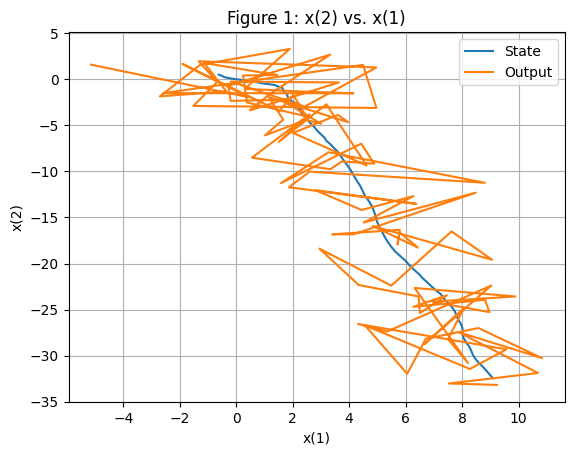

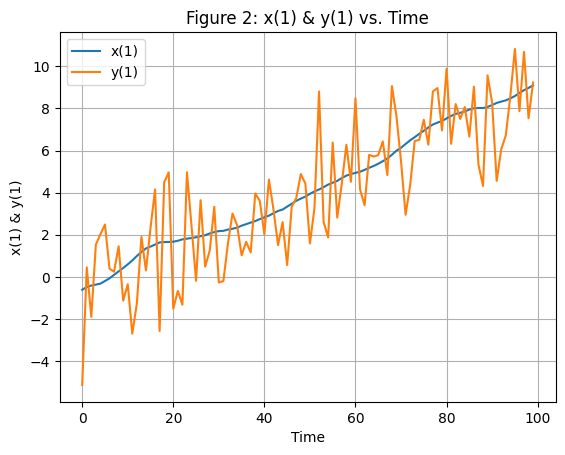

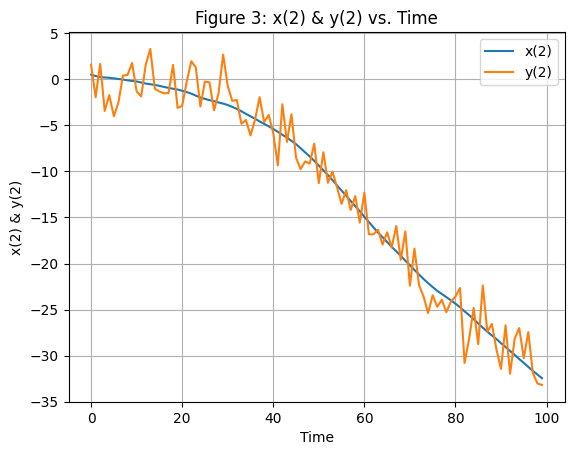

In [7]:
# plot

plt.plot(x[:, 0], x[:, 1], label="State")
plt.plot(y[:, 0], y[:, 1], label="Output")
plt.xlabel("x(1)")
plt.ylabel("x(2)")
plt.title("Figure 1: x(2) vs. x(1)")
plt.grid(True)
plt.legend()
plt.show()

# time
t = np.arange(N)

# plt.figure(figsize=(10, 3))
plt.plot(t, x[:, 0], label="x(1)")
plt.plot(t, y[:, 0], label="y(1)")
plt.xlabel("Time")
plt.ylabel("x(1) & y(1)")
plt.title("Figure 2: x(1) & y(1) vs. Time")
plt.grid(True)
plt.legend()
plt.show()

# plt.figure(figsize=(10, 3))
plt.plot(t, x[:, 1], label="x(2)")
plt.plot(t, y[:, 1], label="y(2)")
plt.xlabel("Time")
plt.ylabel("x(2) & y(2)")
plt.title("Figure 3: x(2) & y(2) vs. Time")
plt.grid(True)
plt.legend()
plt.show()

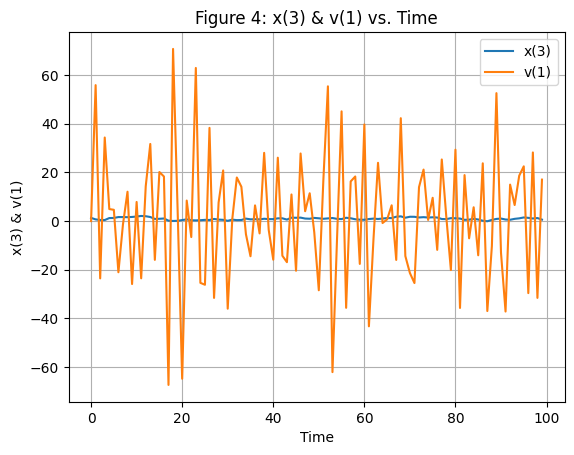

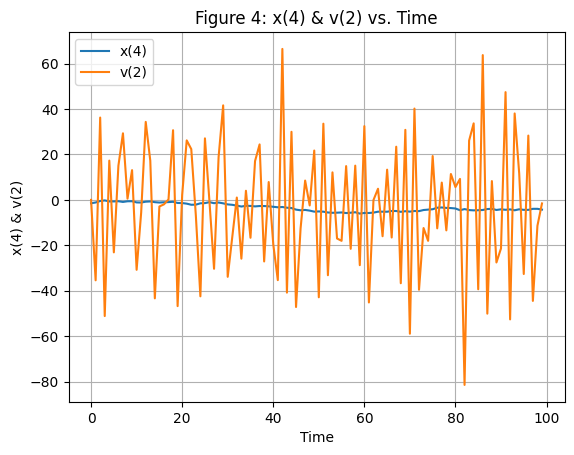

In [8]:
# speed
def speed(yk, yk_prev, dt):
    return (yk - yk_prev) / dt

v = np.zeros((N, 2))

for k in range(N - 1):
    v[k + 1] = speed(yk=y[k + 1], yk_prev=y[k], dt=Ts)
    # print(f'v[{k}]:', v[k])

# plt.figure(figsize=(10, 3))
plt.plot(np.arange(N), x[:, 2], label="x(3)")
plt.plot(np.arange(N), v[:, 0], label="v(1)")
plt.xlabel("Time")
plt.ylabel("x(3) & v(1)")
plt.title("Figure 4: x(3) & v(1) vs. Time")
plt.grid(True)
plt.legend()
plt.show()

# plt.figure(figsize=(10, 3))
plt.plot(np.arange(N), x[:, 3], label="x(4)")
plt.plot(np.arange(N), v[:, 1], label="v(2)")
plt.xlabel("Time")
plt.ylabel("x(4) & v(2)")
plt.title("Figure 4: x(4) & v(2) vs. Time")
plt.grid(True)
plt.legend()
plt.show()

## Problem 3: Causal Kalman Filter

### Problem 3.1

In [9]:
def prediction(A, 
               x_prev_prev, 
               P_prev_prev, 
               Q):
    x_k_prev = np.dot(A, x_prev_prev)
    P_k_prev = np.dot(np.dot(A, P_prev_prev), np.transpose(A)) + Q
    return x_k_prev, P_k_prev

def correction(P_k_prev, 
               C, R, 
               x_k_prev, 
               y_k):
    K_k = np.dot(np.dot(P_k_prev, np.transpose(C)),
                 np.linalg.inv(np.dot(np.dot(C, P_k_prev), 
                                      np.transpose(C)) + R),)
    x_k_k = x_k_prev + np.dot(K_k, (y_k - np.dot(C, x_k_prev)))
    P_k_k = np.dot((np.identity(4) - np.dot(K_k, C)), P_k_prev)
    return K_k, x_k_k, P_k_k

x_k_prev = np.zeros((N, 4))
P_k_prev = np.zeros((N, 4, 4))

K_k = np.zeros((N, 4, 2))
x_k_k = np.zeros((N, 4))
P_k_k = np.zeros((N, 4, 4))

x_k_k[0] = m0
P_k_k[0] = P0

for k in range(N - 1):
    x_k_prev[k + 1], P_k_prev[k + 1] = prediction(A, 
                                                  x_k_k[k], 
                                                  P_k_k[k], 
                                                  Cov_q)
    K_k[k + 1], x_k_k[k + 1], P_k_k[k + 1] = correction(P_k_prev[k + 1], 
                                                        C, R, 
                                                        x_k_prev[k + 1], 
                                                        y[k + 1])
    # print(x_k_prev[k+1], P_k_prev[k + 1], 
    #       K_k[k + 1], x_k_k[k + 1], P_k_k[k + 1])
# print(x_k_k)
# print("P_k_k:",P_k_k)
# print("a:",P_k_k[:, :, 0])

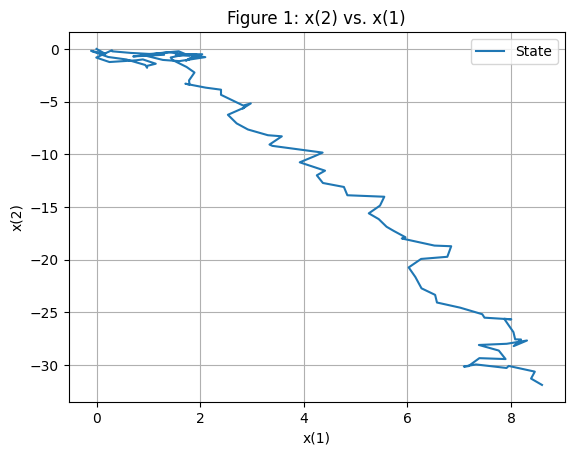

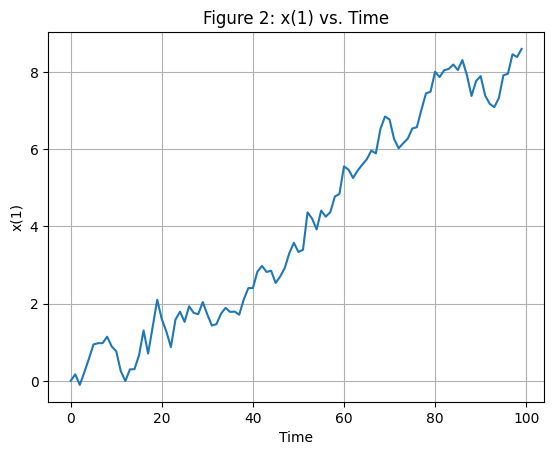

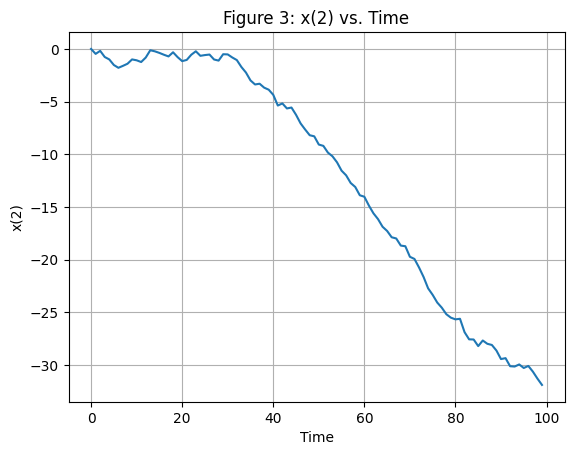

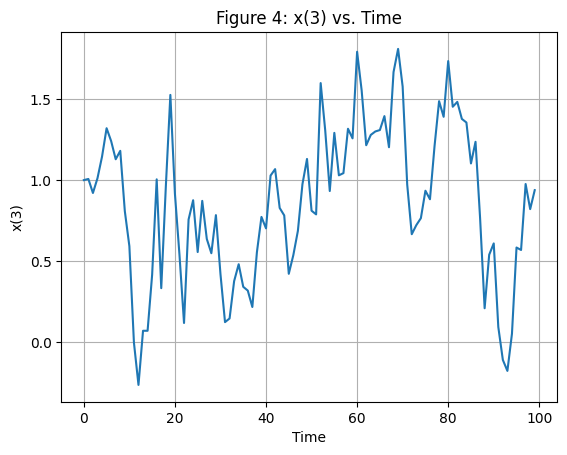

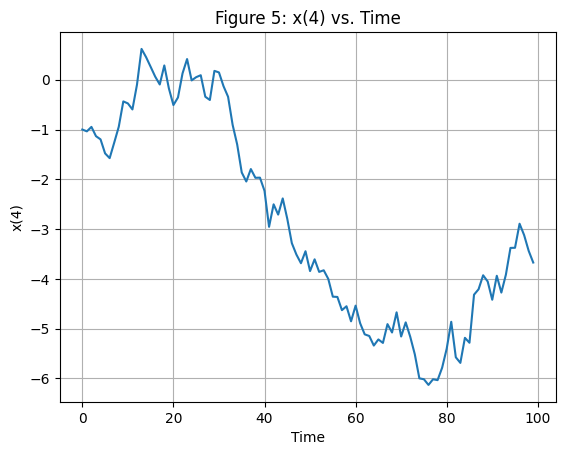

In [10]:
# plot
plt.plot(x_k_k[:, 0], x_k_k[:, 1], label="State")
plt.xlabel("x(1)")
plt.ylabel("x(2)")
plt.title("Figure 1: x(2) vs. x(1)")
plt.grid(True)
plt.legend()
plt.show()

t = np.arange(N)

for k in range(4): 
    # plt.figure(figsize=(10, 30))
    plt.plot(t, x_k_k[:, k], label=f"x({k + 1})")
    # plt.yscale("log")
    plt.xlabel("Time")
    plt.ylabel(f"x({k + 1})")
    plt.title(f"Figure {k + 2}: x({k + 1}) vs. Time")
    plt.grid(True)
    plt.show()

### Problem 3.2

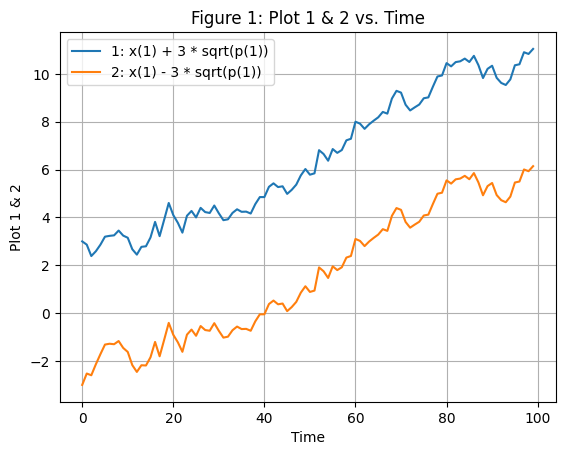

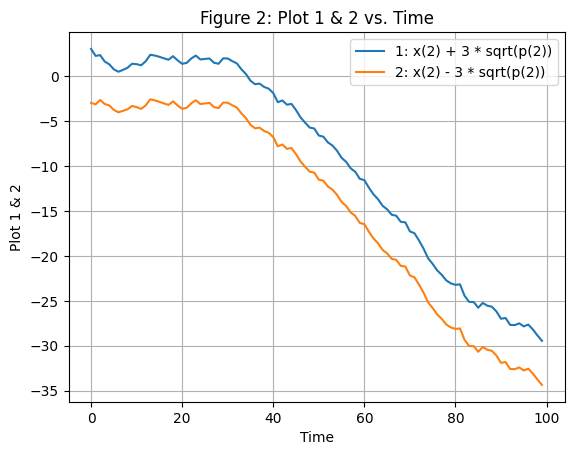

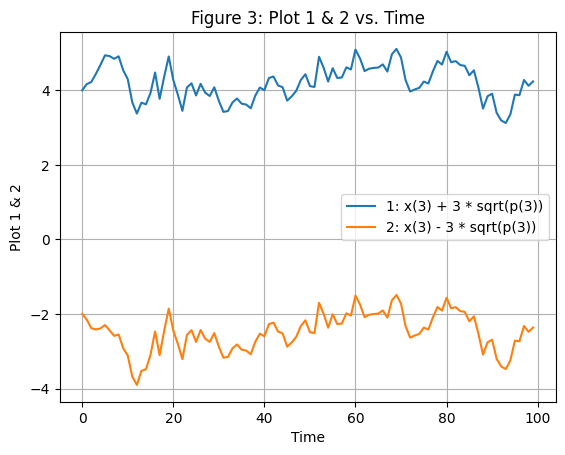

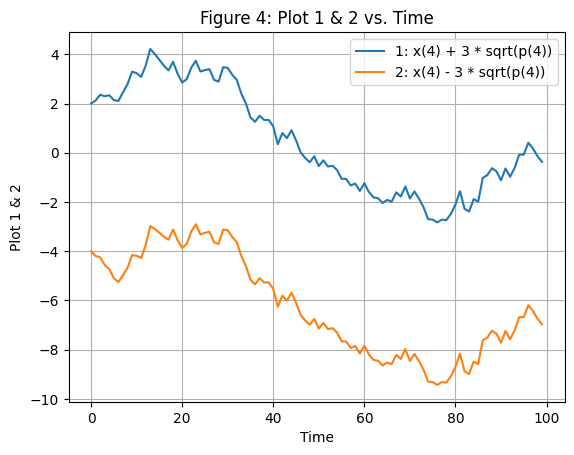

In [11]:
for k in range(4):
    p = P_k_k[:, k, k]
    plot1 = x_k_k[:, k] + 3 * np.sqrt(p)
    plot2 = x_k_k[:, k] - 3 * np.sqrt(p)
    plt.plot(t, plot1, label=f"1: x({k + 1}) + 3 * sqrt(p({k + 1}))")
    plt.plot(t, plot2, label=f"2: x({k + 1}) - 3 * sqrt(p({k + 1}))")
    plt.xlabel("Time")
    plt.ylabel("Plot 1 & 2")
    plt.title(f"Figure {k + 1}: Plot 1 & 2 vs. Time")
    plt.grid(True)
    plt.legend()
    plt.show()
    

## Problem 4: Smooth Kalman Filter

In [12]:
def smooth_prediction(A, x_k_k, P_k_k, Q):
    x_after_k = np.dot(A, x_k_k)
    P_after_k = np.dot(np.dot(A, P_k_k), np.transpose(A)) + Q
    return x_after_k, P_after_k

def smooth_correction(P_k_k, A, P_after_k, x_k_k, xs_after_after, x_after_k, Ps_after_after):
    G_k = np.dot(np.dot(P_k_k, np.transpose(A)), np.linalg.inv(P_after_k))
    xs_k_k = x_k_k + np.dot(G_k, (xs_after_after - x_after_k))
    Ps_k_k = P_k_k + np.dot(np.dot(G_k, (Ps_after_after - P_after_k)), np.transpose(G_k))
    return G_k, xs_k_k, Ps_k_k

In [13]:
x_after_k = np.zeros((N, 4))
P_after_k = np.zeros((N, 4, 4))
G_k = np.zeros((N, 4, 4))

x_k_k = np.zeros((N, 4))
P_k_k = np.zeros((N, 4, 4))

xs_k_k = np.zeros((N, 4))
Ps_k_k = np.zeros((N, 4, 4))

x_k_k[0] = m0
P_k_k[0] = P0

for k in range(N - 1, -1, -1):
    x_after_k[k], P_after_k[k] = smooth_prediction(A,
                                                   x_k_k[k],
                                                   P_k_k[k],
                                                   Cov_q)
    G_k[k], xs_k_k[k], Ps_k_k[k] = smooth_correction(P_k_k[k],
                                                     A,
                                                     P_after_k[k],
                                                     x_k_k[k],
                                                     xs_k_k[k],
                                                     x_after_k[k - 1],
                                                     Ps_k_k[k])
    